In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import os

In [2]:
CWD = os.path.abspath('')

# Data Observation

In [3]:
def get_data(ds_type: str) -> pd.DataFrame:
    """
    :param ds_type: train / test
    """
    path = Path(CWD).parent / f'data/{ds_type}.csv'
    
    return pd.read_csv(path)

In [4]:
def calculate_nan_values(data: pd.DataFrame) -> pd.DataFrame:
    nan_counts = data.isna().sum()
    nan_counts_percent = (data.isna().sum() / len(data)) * 100

    nan_summary = pd.DataFrame({
        'NaN Count': nan_counts,
        'NaN Percent': nan_counts_percent
    })

    nan_summary = nan_summary[nan_summary['NaN Count'] > 0]
    nan_summary = nan_summary.sort_values(by='NaN Count', ascending=False)

    return nan_summary


In [5]:
def plot_nan_info(nan_info: pd.DataFrame, dataset_type: str) -> plt.Axes:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(nan_info.index, nan_info['NaN Percent'], color='coral', edgecolor='black')
    
    ax.set_xlabel('Columns', fontsize=14)
    ax.set_ylabel('NaN Percent (%)', fontsize=14)
    ax.set_title(f'Percentage of NaN Values for {dataset_type}', fontsize=16)
    ax.set_xticks(range(len(nan_info.index)))
    ax.set_xticklabels(nan_info.index, rotation=45, ha='right', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return ax


In [6]:
def preprocess_data(data: pd.DataFrame, dataset_type: str) -> pd.DataFrame:
    nan_summary_initial = calculate_nan_values(data)

    initial_lenght = len(data.columns)
    columns_to_drop = nan_summary_initial[nan_summary_initial["NaN Percent"] > 85].index
    data_cleaned = data.drop(columns=columns_to_drop)

    print(f'{len(columns_to_drop)} (from {initial_lenght} to {len(data_cleaned.columns)}) columns dropped from {dataset_type}')

    nan_summary_cleaned = calculate_nan_values(data_cleaned)

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.bar(
        nan_summary_initial.index, 
        nan_summary_initial['NaN Percent'], 
        color='coral', 
        edgecolor='black', 
        label='Before Cleaning'
    )

    ax.bar(
        nan_summary_cleaned.index, 
        nan_summary_cleaned['NaN Percent'], 
        color='skyblue', 
        edgecolor='black', 
        label='After Cleaning'
    )

    ax.set_xlabel('Columns', fontsize=14)
    ax.set_ylabel('%', fontsize=14)
    ax.set_title(f'Comparison of NaN Values Drop', fontsize=16)
    ax.set_xticks(range(len(nan_summary_initial.index)))
    ax.set_xticklabels(nan_summary_initial.index, rotation=45, ha='right', fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    fig.text(0.5, 0.6, dataset_type, fontsize=40, color='gray', alpha=0.3, ha='center', va='center')   

    plt.tight_layout()
    plt.show()

    return data

4 (from 70 to 66) columns dropped from train


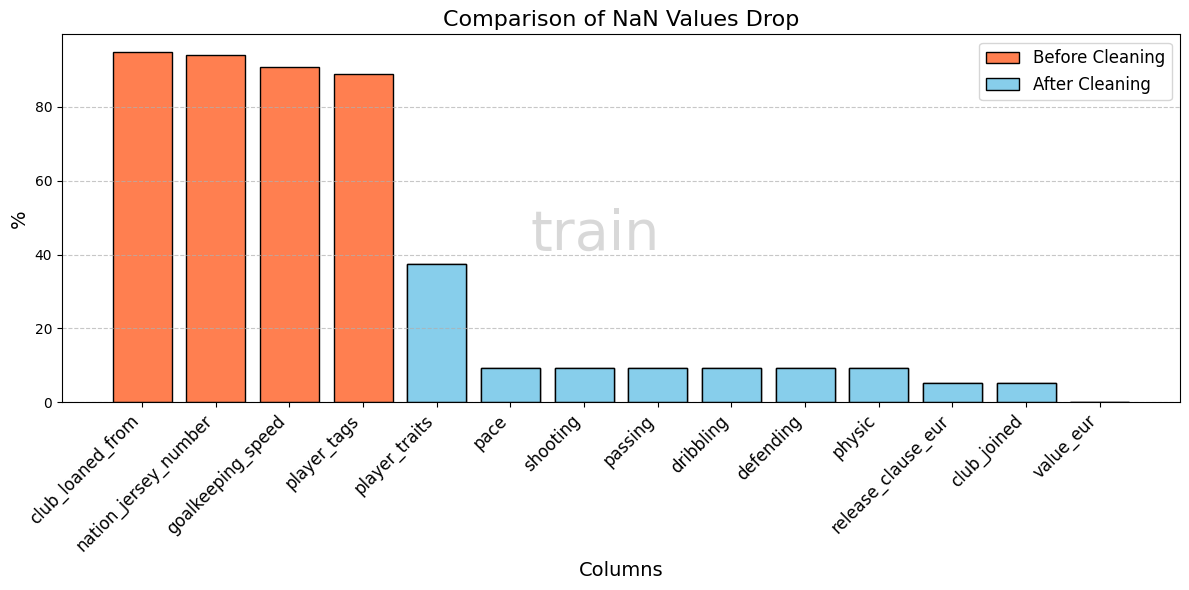

In [7]:
train_data = get_data("train")

train_data = preprocess_data(data=train_data, dataset_type="train")


# Target column analysis

In [8]:
def plot_dist(data: pd.DataFrame, column: str) -> None:
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data[column], 
        kde=True,  
        color='coral', 
        bins=30
    )
    plt.title(f'Distribution of {column.capitalize()}', fontsize=16)
    plt.xlabel(column.capitalize(), fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

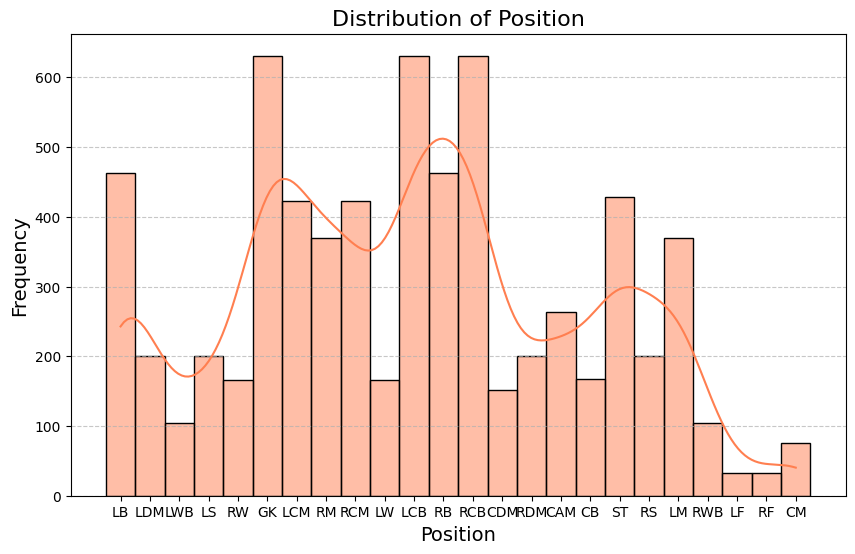

In [9]:
plot_dist(train_data, "position")

# Categorical Analysis (Not implemented fully)

In [10]:
for col in train_data.select_dtypes(include=['object', 'category']).columns:
    print(f'Categorical column {col} has {train_data[col].nunique()} unique values')

Categorical column short_name has 6692 unique values
Categorical column birthday_date has 3991 unique values
Categorical column club_name has 701 unique values
Categorical column league_name has 55 unique values
Categorical column club_loaned_from has 196 unique values
Categorical column club_joined has 1263 unique values
Categorical column nationality_name has 144 unique values
Categorical column preferred_foot has 2 unique values
Categorical column work_rate has 9 unique values
Categorical column body_type has 10 unique values
Categorical column real_face has 2 unique values
Categorical column player_tags has 61 unique values
Categorical column player_traits has 772 unique values
Categorical column position has 24 unique values


In [11]:
def plot_categorical_dist(data: pd.DataFrame, n: int = 10) -> None:
    """
    Plots categorical parameters

    :param n: top n of unique values
    """
    categorical_columns = [
        col for col in data.select_dtypes(include=['object', 'category']).columns
    ]

    n_cols = 3
    n_rows = (len(categorical_columns) + n_cols - 1) // n_cols 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
    axes = axes.flatten() 

    for i, col in enumerate(categorical_columns):
        top_categories = data[col].value_counts().head(10)

        sns.barplot(
            x=top_categories.index,
            y=top_categories.values,
            hue=top_categories.values,
            ax=axes[i],
            palette="coolwarm"
        )
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel('Category', fontsize=12)
        axes[i].set_ylabel('Frequency', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(len(categorical_columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

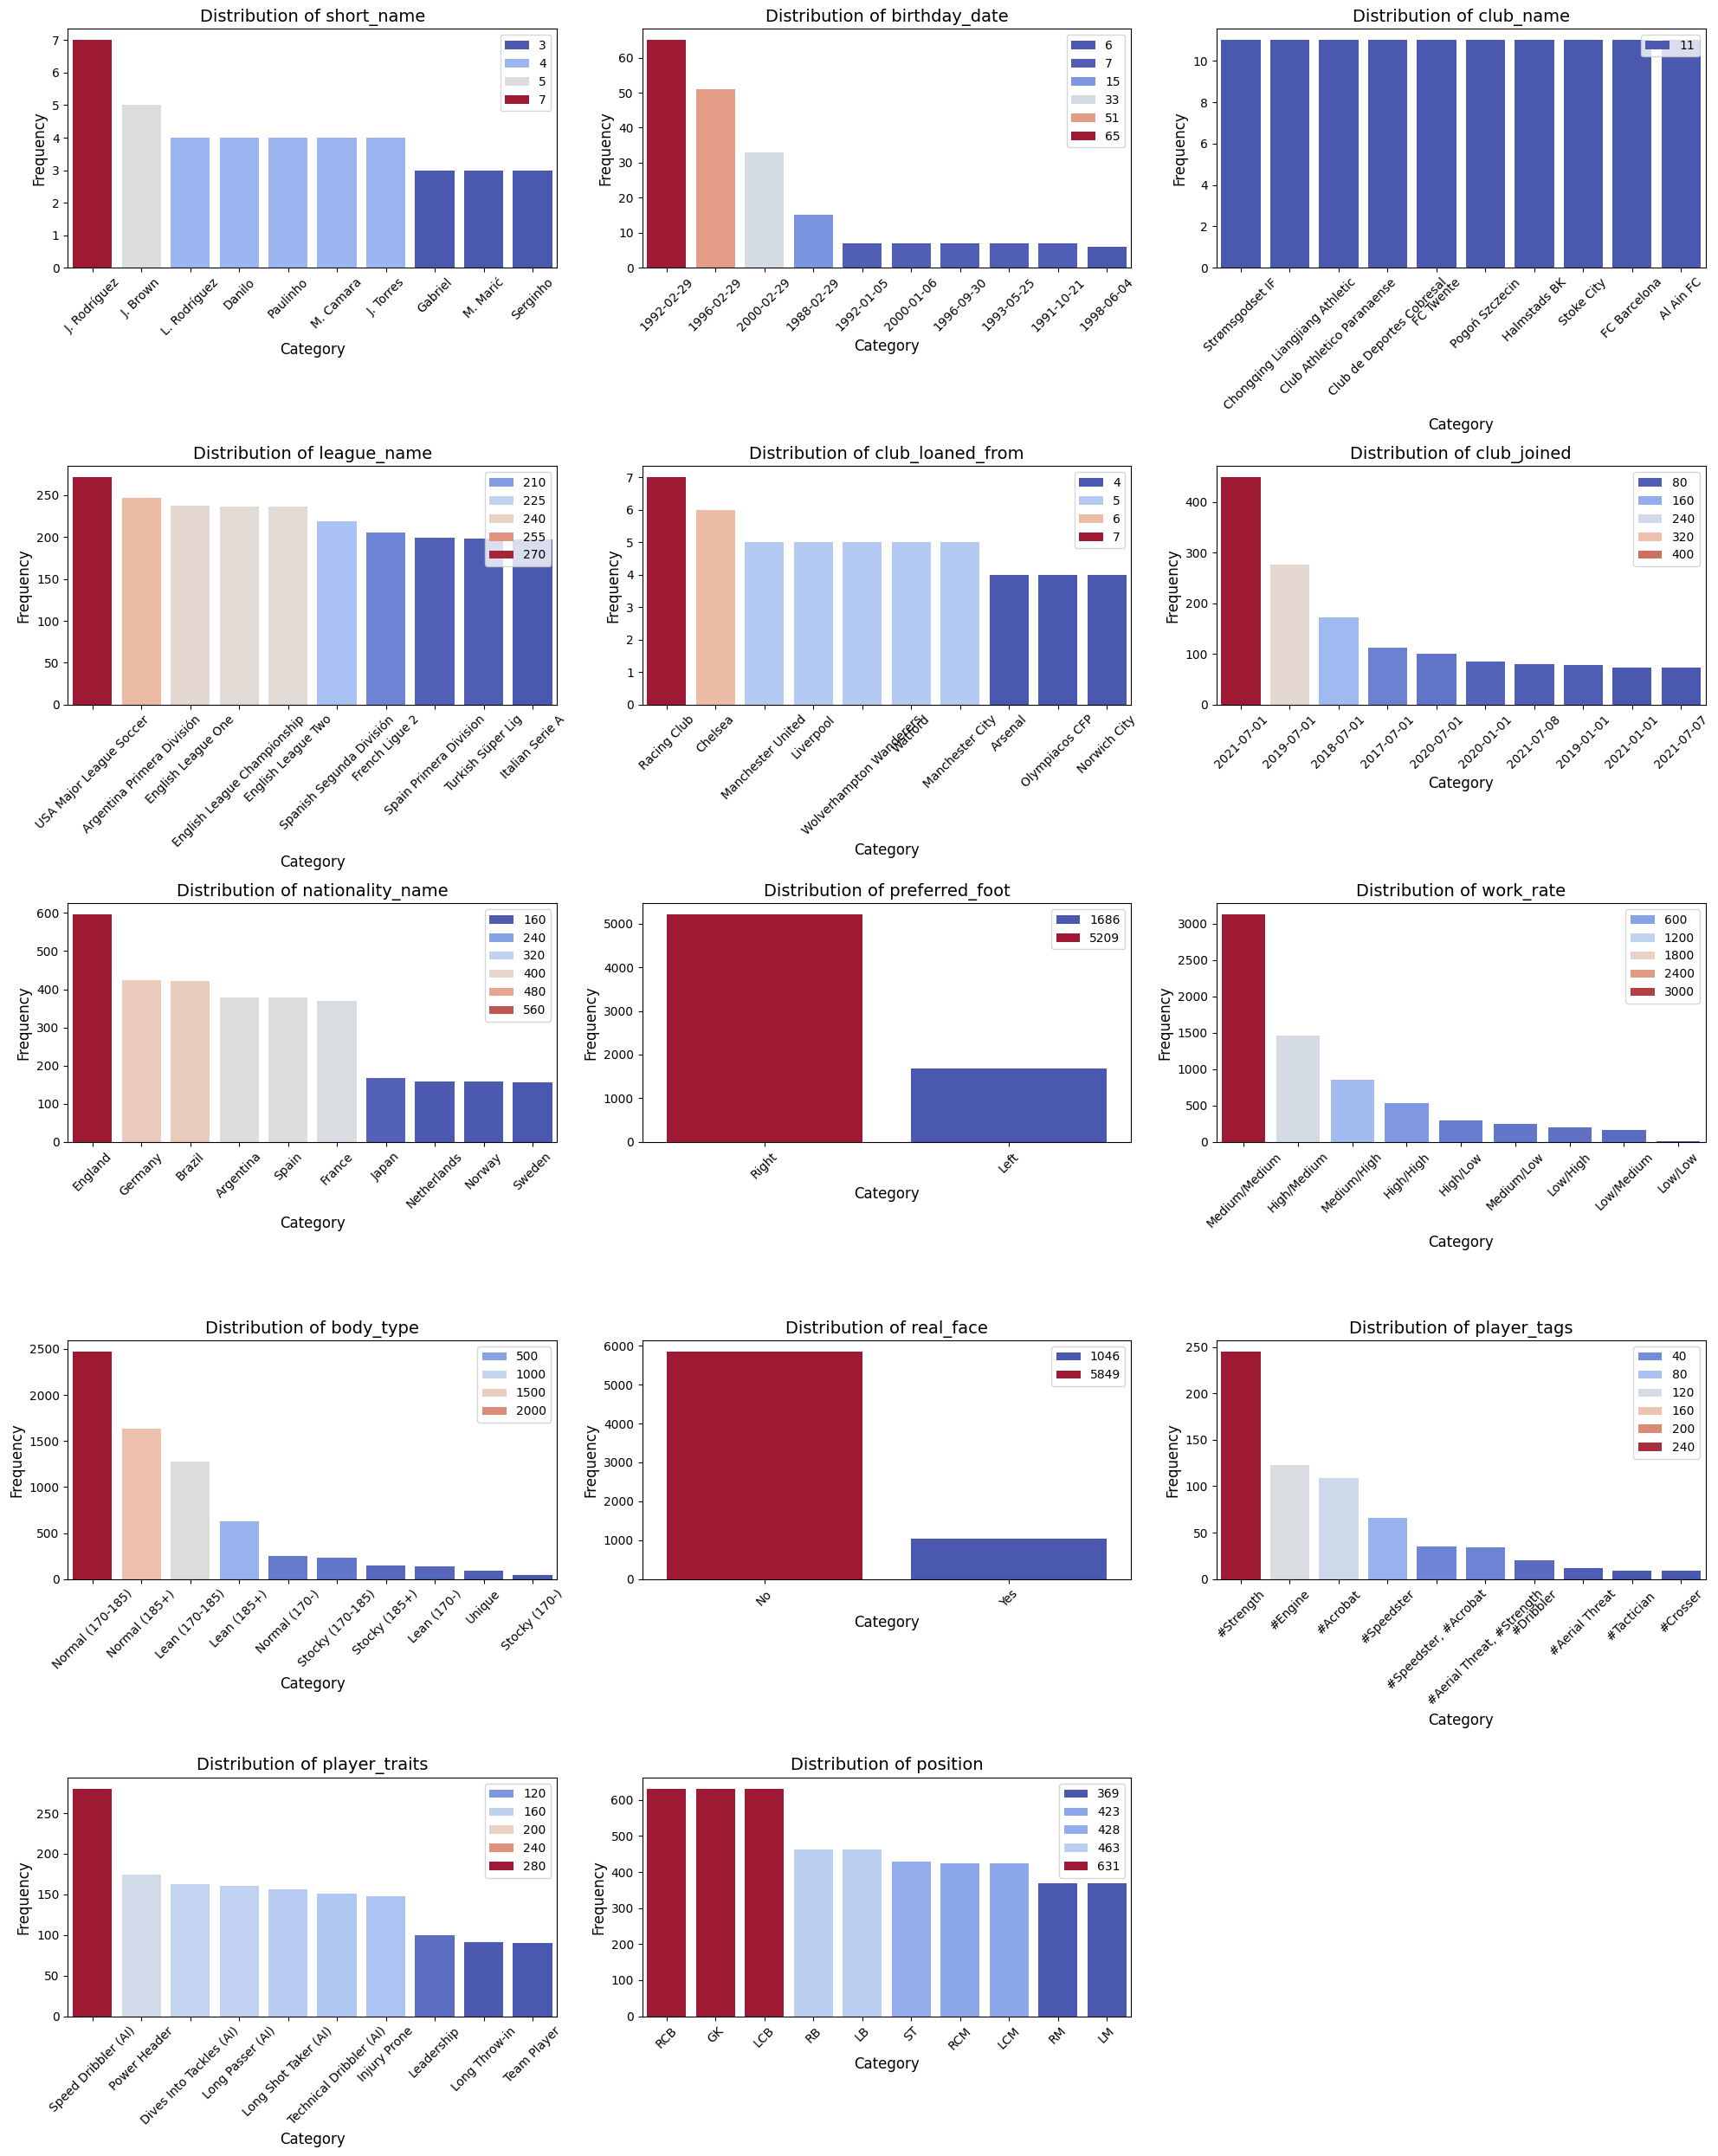

In [12]:
plot_categorical_dist(data=train_data)

# Numerical Analysis

In [13]:
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

train_data[numeric_columns].describe()

,id,overall,potential,value_eur,wage_eur,height_cm,weight_kg,league_level,club_jersey_number,club_contract_valid_until,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,6895.000000,6895.000000,6895.000000,6.893000e+03,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,...,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,6895.000000,631.000000
mean,223463.552719,68.825671,72.031327,4.320388e+06,12034.126178,181.478898,75.527919,1.361856,16.442350,2022.754605,...,61.875997,51.281653,52.249021,49.736766,15.897317,15.690210,15.558666,15.819144,16.003046,40.220285
std,26876.952793,5.950459,6.070890,1.052554e+07,24630.820430,6.862683,7.041120,0.760018,15.440185,1.204310,...,10.937084,19.654312,20.898714,20.613351,17.451010,16.752522,16.316593,17.159677,17.854369,10.218593
min,41.000000,49.000000,53.000000,2.500000e+04,500.000000,156.000000,53.000000,1.000000,1.000000,2021.000000,...,12.000000,4.000000,5.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,15.000000
25%,207602.500000,65.000000,68.000000,7.250000e+05,2000.000000,177.000000,70.000000,1.000000,6.000000,2022.000000,...,56.000000,35.000000,34.000000,31.000000,8.000000,8.000000,8.000000,8.000000,8.000000,33.000000
50%,227951.000000,68.000000,72.000000,1.400000e+06,4000.000000,182.000000,75.000000,1.000000,13.000000,2023.000000,...,63.000000,58.000000,61.000000,58.000000,11.000000,11.000000,11.000000,11.000000,11.000000,41.000000
75%,242423.500000,72.000000,76.000000,2.900000e+06,12000.000000,186.000000,80.000000,1.000000,22.000000,2024.000000,...,69.000000,66.000000,68.000000,66.000000,14.000000,14.000000,14.000000,14.000000,14.000000,47.000000
max,264481.000000,93.000000,95.000000,1.940000e+08,350000.000000,203.000000,103.000000,5.000000,99.000000,2028.000000,...,96.000000,90.000000,93.000000,92.000000,91.000000,92.000000,91.000000,92.000000,90.000000,65.000000


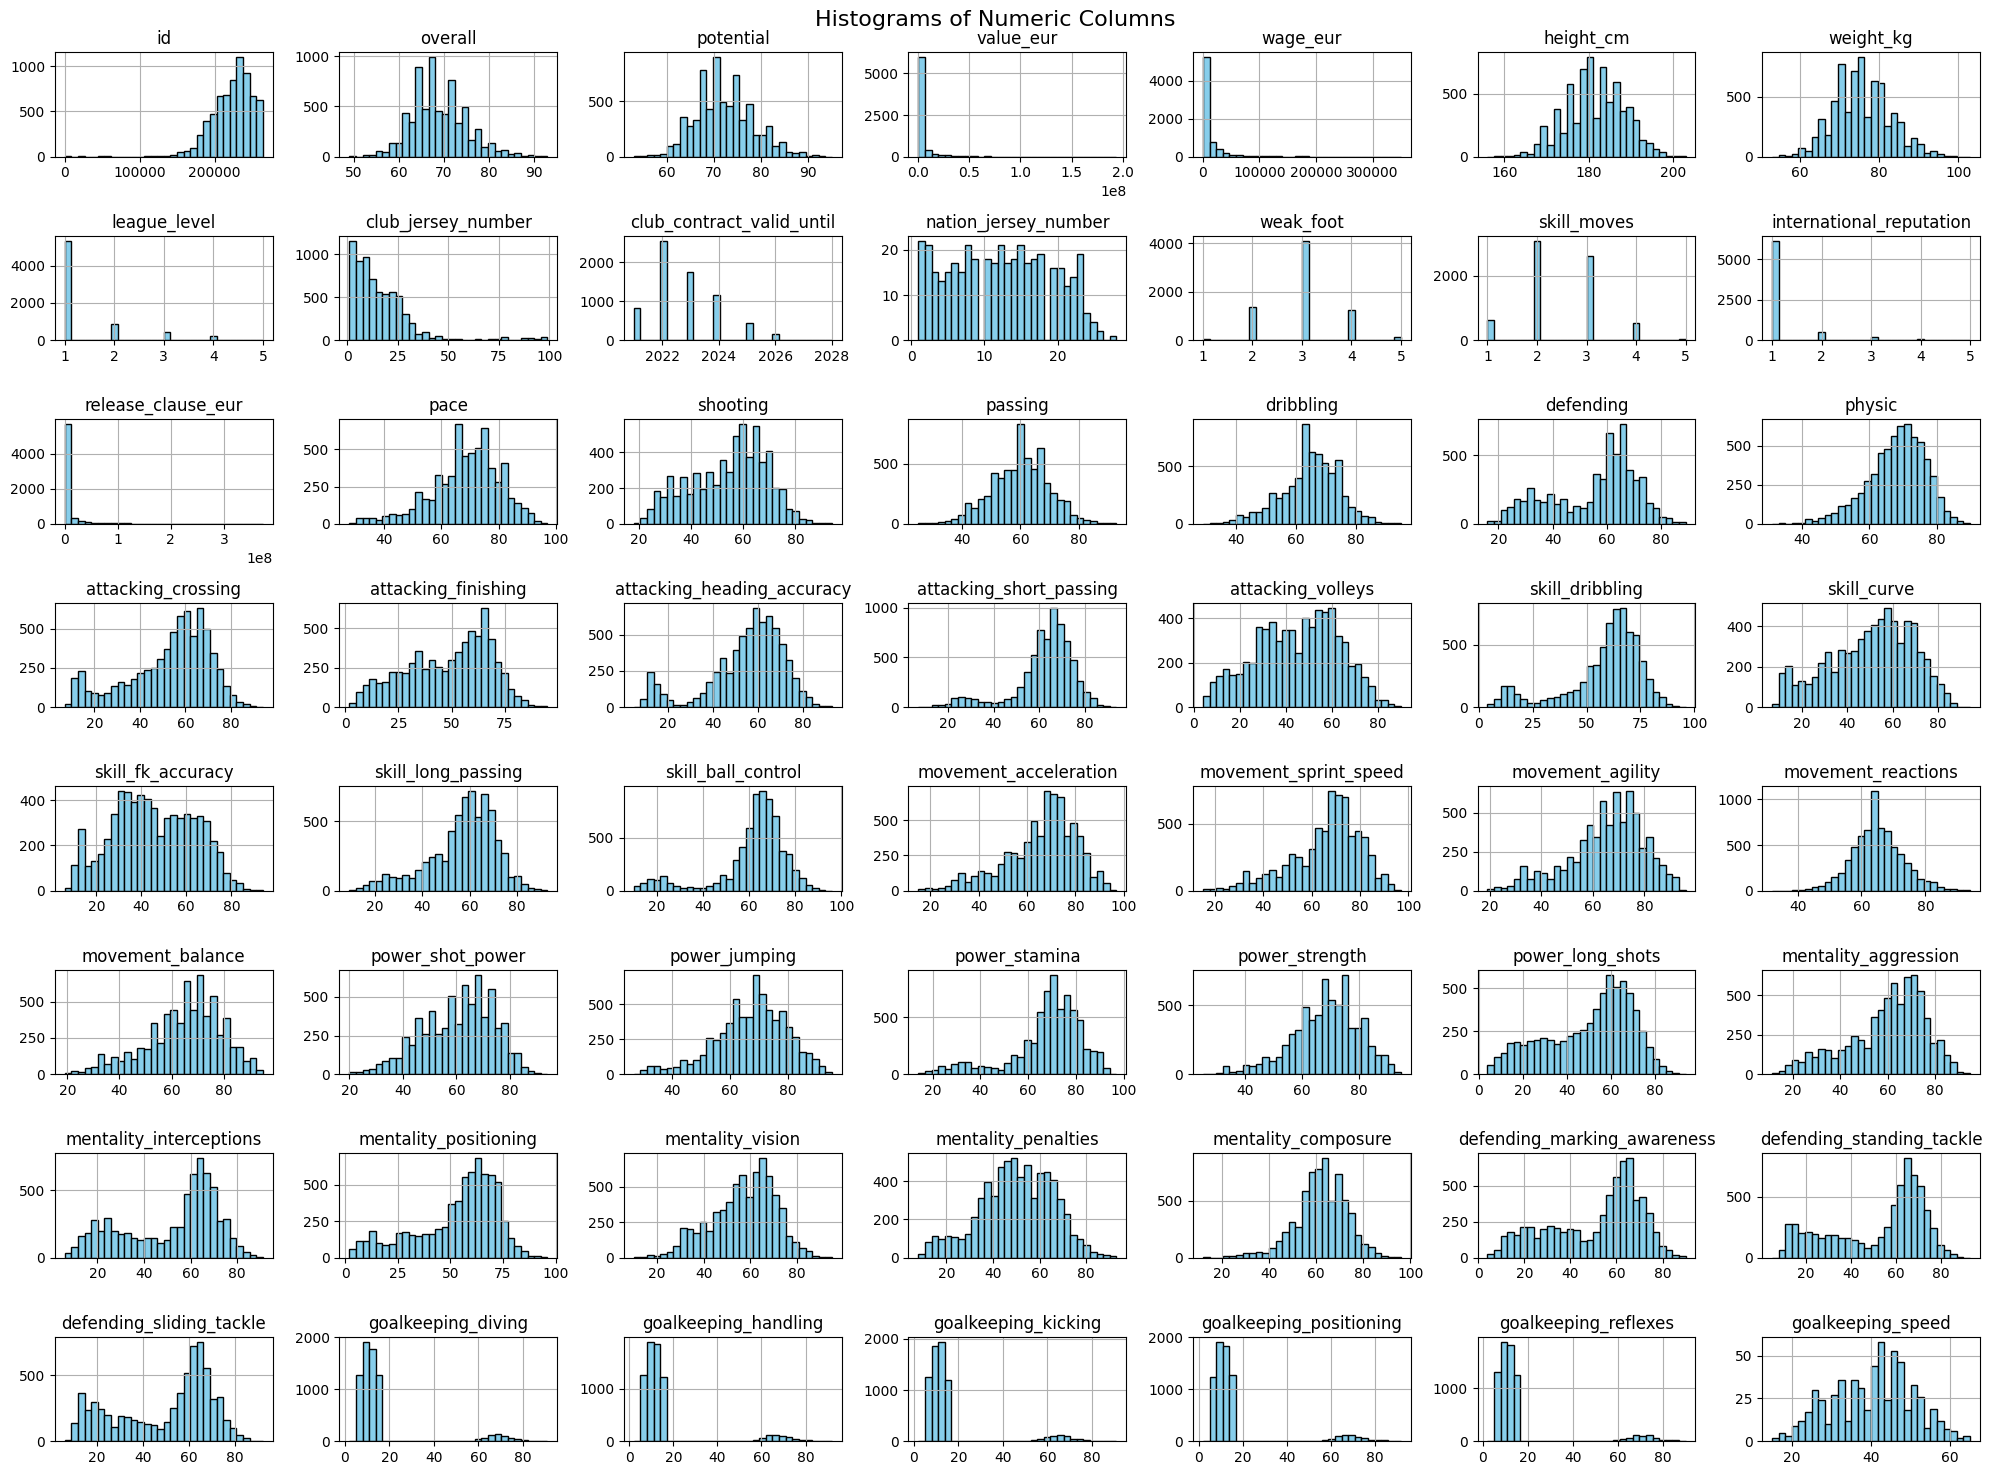

In [14]:
train_data[numeric_columns].hist(bins=30, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
correlation_matrix = train_data[numeric_columns].corr()

# Since we have a lot of variables, we need to extract only those, what have high correaltion
correlation_threshold = 0.9

correlated_pairs = []

for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if col != idx and abs(correlation_matrix.loc[idx, col]) > correlation_threshold:
            correlated_pairs.append((idx, col, correlation_matrix.loc[idx, col]))

correlated_pairs_df = pd.DataFrame(correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
correlated_pairs_df = correlated_pairs_df.drop_duplicates()

print("Highly correlated pairs:")
print(correlated_pairs_df)


Highly correlated pairs:
                  Feature 1             Feature 2  Correlation
0        release_clause_eur             value_eur     0.995700
1                 value_eur    release_clause_eur     0.995700
2     movement_acceleration                  pace     0.962618
3     movement_sprint_speed                  pace     0.974853
4       attacking_finishing              shooting     0.968797
..                      ...                   ...          ...
61     goalkeeping_handling  goalkeeping_reflexes     0.971948
62      goalkeeping_kicking  goalkeeping_reflexes     0.967557
63  goalkeeping_positioning  goalkeeping_reflexes     0.972248
64    movement_acceleration     goalkeeping_speed     0.974757
65    movement_sprint_speed     goalkeeping_speed     0.940949

[66 rows x 3 columns]
